# 1. (5 pontos) Faça uma predição das ações da petrobás PETR4 para os próximos 2 dias

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as tt

In [6]:
tickerData = yf.Ticker("PETR4.SA")

tickerDf = tickerData.history(period='1y', interval='1d')

tickerClose = tickerDf.Close

daily_returns = tickerClose

print(daily_returns)

Date
2023-08-21 00:00:00-03:00    26.286045
2023-08-22 00:00:00-03:00    26.686476
2023-08-23 00:00:00-03:00    28.107548
2023-08-24 00:00:00-03:00    28.063955
2023-08-25 00:00:00-03:00    27.872154
                               ...    
2024-08-13 00:00:00-03:00    37.110001
2024-08-14 00:00:00-03:00    37.759998
2024-08-15 00:00:00-03:00    38.340000
2024-08-16 00:00:00-03:00    38.500000
2024-08-19 00:00:00-03:00    38.439999
Name: Close, Length: 249, dtype: float64


In [7]:
daily_returns.index = pd.to_datetime(daily_returns.index)
daily_returns.index = (daily_returns.index - daily_returns.index[0]).days

min_day = daily_returns.index.min()
max_day = daily_returns.index.max()

print(daily_returns)
normalized_index = (daily_returns.index - min_day) / (max_day - min_day)

daily_returns.index = normalized_index

daily_returns

Date
0      26.286045
1      26.686476
2      28.107548
3      28.063955
4      27.872154
         ...    
358    37.110001
359    37.759998
360    38.340000
361    38.500000
364    38.439999
Name: Close, Length: 249, dtype: float64


,Close
Date,
0.000000,26.286045
0.002747,26.686476
0.005495,28.107548
0.008242,28.063955
0.010989,27.872154
...,...
0.983516,37.110001
0.986264,37.759998
0.989011,38.340000


[Text(0.5, 1.0, 'y train-test split '), Text(0.5, 0, 't'), Text(0, 0.5, '')]

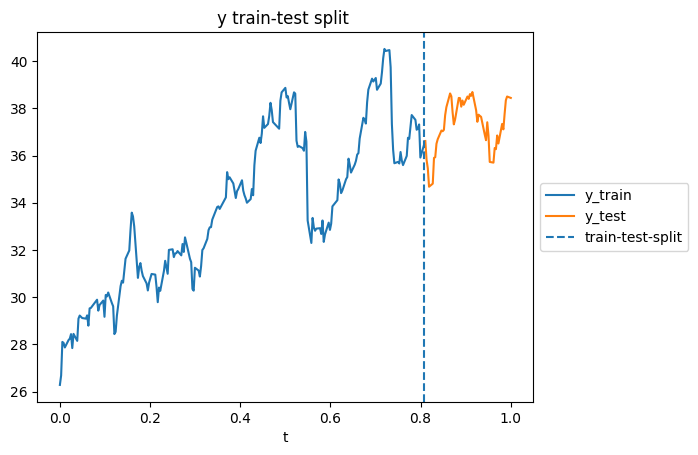

In [8]:
x = daily_returns.index.values.T
y = daily_returns.values.T
n = len(daily_returns)

prop_train = 0.8
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='')

In [9]:
with pm.Model() as model_PETR4:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=1)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=1)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=1)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0.5,0.05)
    trend = pm.Deterministic("trend",a + b*x_train)
    M = pm.gp.mean.Linear([b],a)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [10]:
with model_PETR4:
  prior = pm.sample_prior_predictive()

In [12]:
prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<ipython-input-13-eb70643cfcc9>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
<ipython-input-13-eb70643cfcc9>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

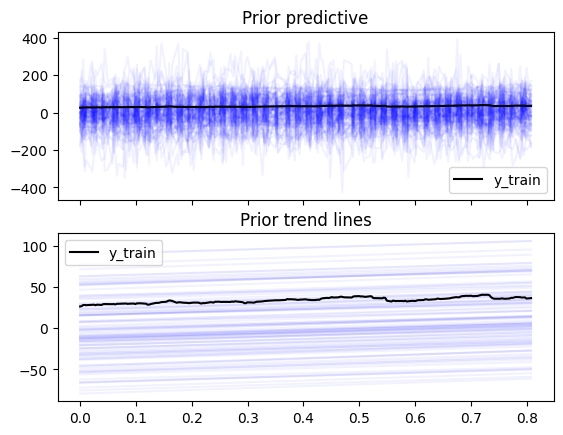

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [14]:
with pm.Model() as model_PETR4:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0,0.125) # change
    trend = pm.Deterministic("trend",a + b*x_train)
    M = pm.gp.mean.Linear([b],a)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [15]:
with model_PETR4:
  prior = pm.sample_prior_predictive()

<ipython-input-16-eb70643cfcc9>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
<ipython-input-16-eb70643cfcc9>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

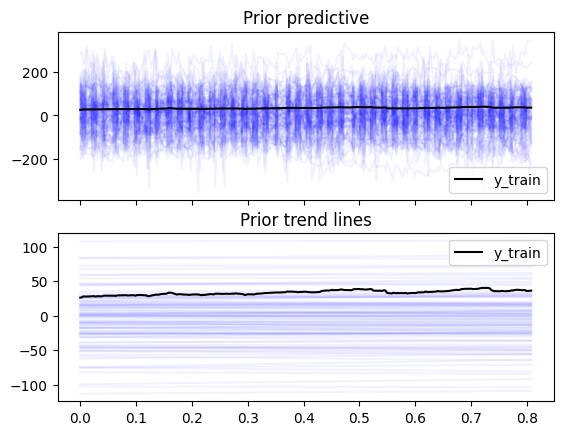

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [17]:
with model_PETR4:
  trace_approx = pm.fit()
  trace = trace_approx.sample()

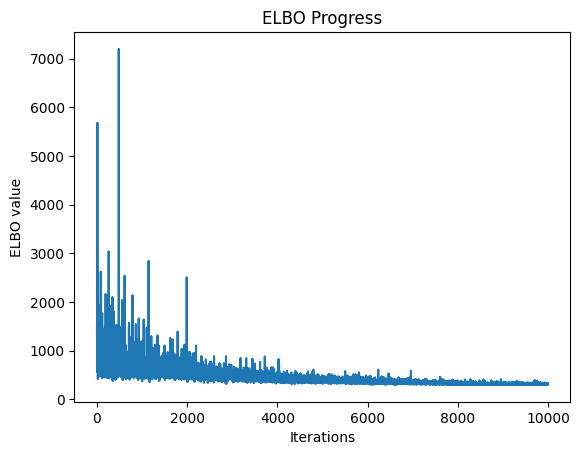

In [18]:
plt.plot(trace_approx.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [19]:
with model_PETR4:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive(trace, var_names=["x_test"])

In [20]:
pred_m

Inference data with groups:
	> posterior_predictive
	> observed_data

<ipython-input-21-de5a17511722>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_test"],


Text(0.5, 1.0, 'Posterior predictive')

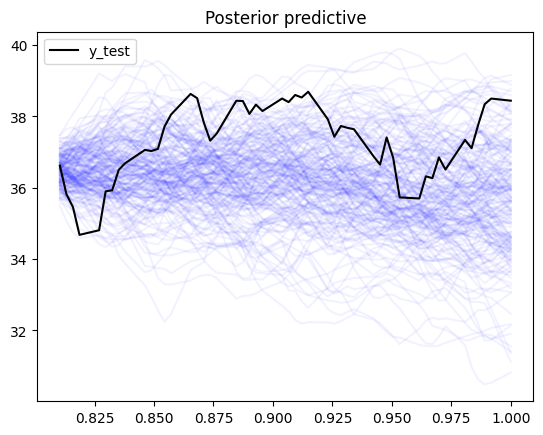

In [21]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_test"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [22]:
with pm.Model() as model_PETR4_2:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=1) # sigma=1
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=1)  # sigma=1
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=1)  # sigma=1

    l_expquad = pm.HalfNormal('l_expquad', sigma=2)  # sigma=2
    sigma_expquad = pm.HalfNormal('sigma_expquad', sigma=2)  # sigma=2
    cov_expquad = sigma_expquad * pm.gp.cov.ExpQuad(1, l_expquad)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.5)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.5)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32 + cov_expquad

    gp = pm.gp.Marginal(cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    wn = pm.gp.cov.WhiteNoise(sigma)

    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=wn)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [23]:
with model_PETR4_2:
  prior = pm.sample_prior_predictive()

<ipython-input-24-1fd1bb1ae432>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]


Text(0.5, 1.0, 'Prior predictive')

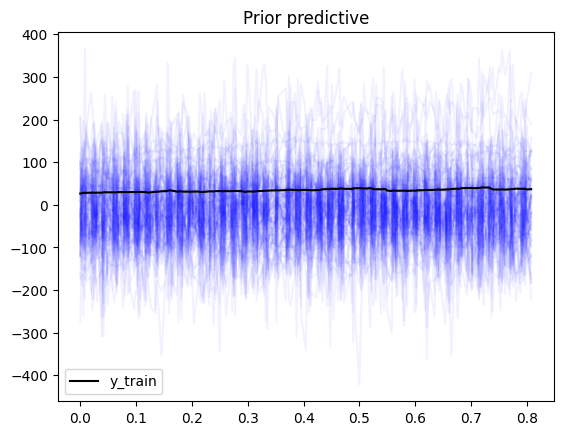

In [24]:
fig, ax = plt.subplots()
ax.plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax)
ax.set_title("Prior predictive")

In [25]:
with model_PETR4_2:
  trace_approx_2 = pm.fit()
  trace_2 = trace_approx_2.sample()

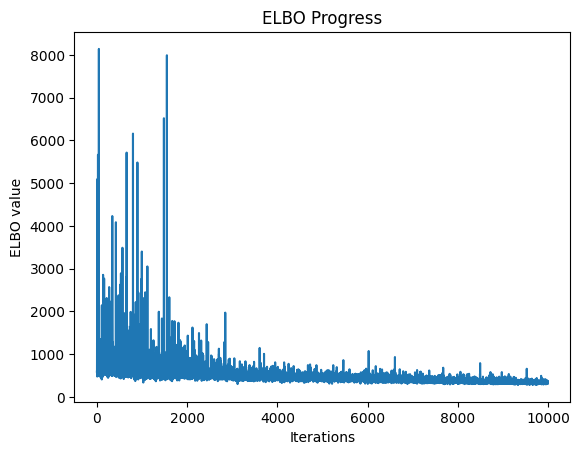

In [26]:
plt.plot(trace_approx_2.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [28]:
with model_PETR4_2:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m_2 = pm.sample_posterior_predictive(trace_2, var_names=["x_test"])

<ipython-input-29-2d2c3d0b8cf7>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_2, group="posterior_predictive", num_samples=200)["x_test"],


Text(0.5, 1.0, 'Posterior predictive')

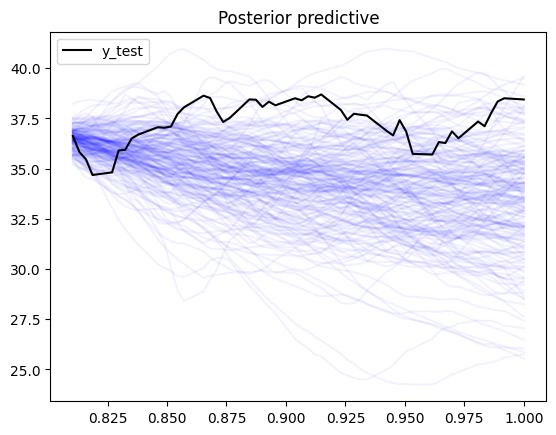

In [29]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(pred_m_2, group="posterior_predictive", num_samples=200)["x_test"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [30]:
import pytensor.tensor as tt
class PiecewiseLinear(pm.gp.mean.Mean):
    def __init__(self, breakpoint, intercept, slope1, slope2):
        super().__init__()
        self.breakpoint = breakpoint
        self.intercept = intercept
        self.slope1 = slope1
        self.slope2 = slope2
        self.trend = list()

    def __call__(self, X):
        X1 = X.flatten()
        trend = tt.switch(X1 < self.breakpoint,
                         self.intercept + self.slope1 * X1,
                         self.intercept + self.slope1 * self.breakpoint + self.slope2 * (X1 - self.breakpoint))
        #pm.Deterministic("trend",trend)
        return trend


In [31]:
with pm.Model() as model_PETR4_3:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    bp = pm.Normal('breakpoint', mu=0.4, sigma=0.1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope1 = pm.Normal('slope1', mu=-1, sigma=1)
    slope2 = pm.Normal('slope2', mu=1, sigma=1)
    M = PiecewiseLinear(bp,intercept,slope1,slope2)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [32]:
with model_PETR4_3:
  prior = pm.sample_prior_predictive()

In [33]:
prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [35]:
with model_PETR4_3:
  trace_approx_3 = pm.fit()
  trace_3 = trace_approx_3.sample()

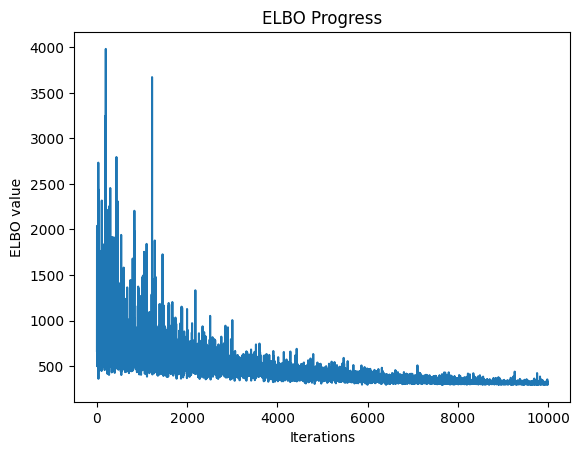

In [36]:
plt.plot(trace_approx_3.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [37]:
with model_PETR4_3:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m_3 = pm.sample_posterior_predictive(trace_3, var_names=["x_test"])

<ipython-input-38-2911012fecb0>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_3, group="posterior_predictive", num_samples=200)["x_test"],


Text(0.5, 1.0, 'Posterior predictive')

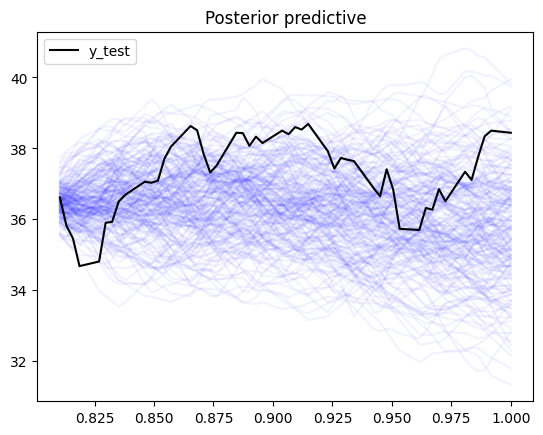

In [38]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(pred_m_3, group="posterior_predictive", num_samples=200)["x_test"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [39]:
f_pred_samples = az.extract(pred_m_3, group="posterior_predictive", var_names=["x_test"])
f_pred_samples

<xarray.DataArray 'x_test' (x_test_dim_2: 50, sample: 500)> Size: 200kB
array([[36.76377984, 36.98257282, 36.90922427, ..., 36.10474044,
        35.62073441, 36.28876192],
       [36.75026692, 36.85095245, 37.06459605, ..., 36.01792436,
        35.40897487, 36.26062137],
       [36.75279542, 36.6041043 , 37.23901609, ..., 36.03031557,
        35.41153108, 36.38141295],
       ...,
       [34.20740912, 34.22374651, 36.80558933, ..., 35.47589209,
        33.28051171, 36.75434797],
       [34.14256172, 34.26936579, 36.77027685, ..., 35.48729619,
        33.3040879 , 36.65395291],
       [34.20275998, 34.05495537, 36.33017436, ..., 35.60877707,
        33.38690611, 36.08923988]])
Coordinates:
  * x_test_dim_2  (x_test_dim_2) int64 400B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * sample        (sample) object 4kB MultiIndex
  * chain         (sample) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499

<Axes: >

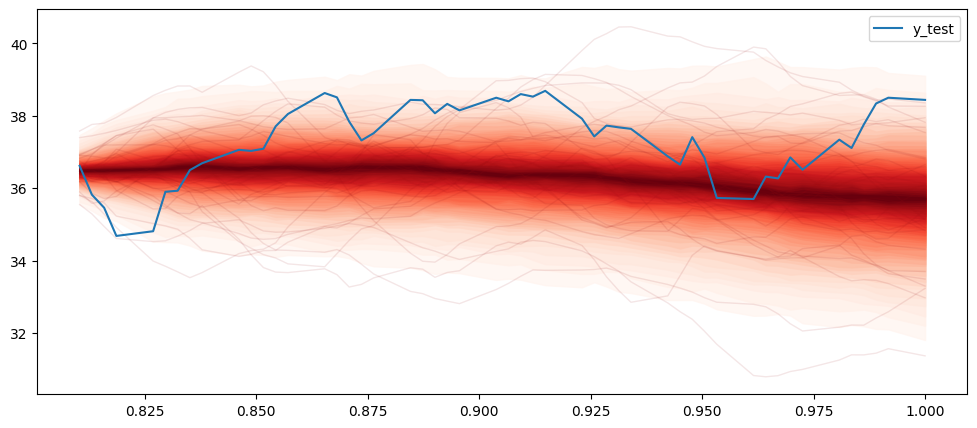

In [40]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples.T, x_test);

sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)

In [41]:
y_pred = pred_m_3.posterior_predictive["x_test"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_test).sum()/len(y_test)}")

MAE: 1.3004817614398063


O modelo realizado propõe que existe uma diferença média de $1.30 no preço diário (predição) na PETR4, de acordo com os dados de teste.

## Prophet model

In [42]:
x_train # dias

array([0.        , 0.00274725, 0.00549451, 0.00824176, 0.01098901,
       0.01923077, 0.02197802, 0.02472527, 0.02747253, 0.03021978,
       0.03846154, 0.04120879, 0.04395604, 0.04945055, 0.05769231,
       0.06043956, 0.06318681, 0.06593407, 0.06868132, 0.07692308,
       0.07967033, 0.08241758, 0.08516484, 0.08791209, 0.09615385,
       0.0989011 , 0.10164835, 0.1043956 , 0.10714286, 0.11538462,
       0.11813187, 0.12087912, 0.12362637, 0.12637363, 0.13461538,
       0.13736264, 0.14010989, 0.1456044 , 0.15384615, 0.15659341,
       0.15934066, 0.16208791, 0.16483516, 0.17307692, 0.17582418,
       0.17857143, 0.18131868, 0.18406593, 0.19230769, 0.19505495,
       0.1978022 , 0.2032967 , 0.21153846, 0.21428571, 0.21703297,
       0.21978022, 0.22252747, 0.23076923, 0.23351648, 0.23901099,
       0.24175824, 0.25      , 0.25274725, 0.25549451, 0.25824176,
       0.26098901, 0.26923077, 0.27197802, 0.27472527, 0.27747253,
       0.28021978, 0.28846154, 0.29120879, 0.29395604, 0.29670

In [43]:
y_train # valores

array([26.28604507, 26.68647575, 28.10754776, 28.06395531, 27.87215424,
       28.18601227, 28.24703979, 28.43883705, 27.84599876, 28.44755936,
       28.1511364 , 29.09270096, 29.22347832, 29.11885834, 29.09270096,
       29.23219299, 28.79628372, 29.52861404, 29.54605103, 29.75529099,
       29.82503319, 29.89478111, 29.43271255, 29.66810799, 29.85990906,
       29.17116737, 30.09530258, 30.03427696, 30.19991875, 29.74657059,
       29.61579895, 28.43883705, 28.53473854, 29.21475983, 30.47018623,
       30.69685936, 30.61839294, 31.62970543, 31.97843742, 32.84154129,
       33.58259201, 33.42565918, 32.99846649, 30.81890869, 31.28097916,
       31.44662094, 31.12405014, 30.8973732 , 30.5835247 , 30.28710556,
       30.61839294, 30.98456001, 30.95840073, 30.44402885, 29.79016113,
       30.4091568 , 30.26966476, 31.11532974, 31.54253006, 30.9932785 ,
       32.0045929 , 32.03074646, 31.69945335, 31.85460281, 31.86366081,
       31.95426369, 31.77306175, 32.25323486, 31.91802025, 32.53

In [44]:
with pm.Model() as prophet_PETR4:
    X_ = pm.MutableData("X",x_train)
    y_ = pm.MutableData("y",y_train)

    bp = pm.Normal('breakpoint', mu=0.4, sigma=0.1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope1 = pm.Normal('slope1', mu=-1, sigma=1)
    slope2 = pm.Normal('slope2', mu=1, sigma=1)

    trend = tt.switch(X_ < bp,
              intercept + slope1 * X_,
              intercept + slope1 * bp + slope2 * (X_ - bp))

    trend = pm.Deterministic("trend", trend)

    σ = pm.HalfNormal("σ", sigma=1)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y_)

In [45]:
with prophet_PETR4:
  p_prior = pm.sample_prior_predictive()

<ipython-input-46-072e78c728ae>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior, group="prior_predictive", num_samples=100)["likelihood"]
<ipython-input-46-072e78c728ae>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

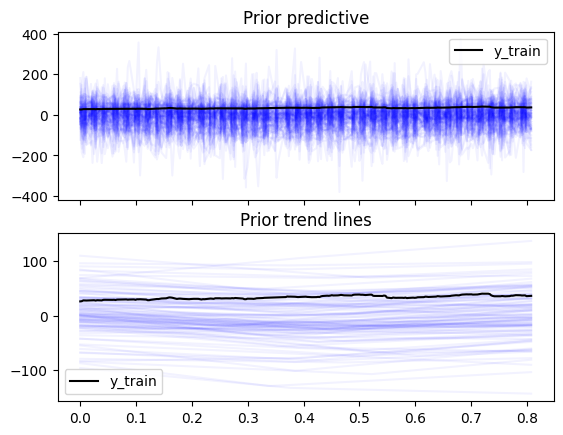

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(p_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(p_prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [47]:
with prophet_PETR4:
  trace = pm.sample()

In [48]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
breakpoint,-1.059,0.052,-1.162,-0.970,0.002,0.001,1141.0,1255.0,1.0
intercept,7.146,0.986,5.300,8.966,0.031,0.022,1006.0,1080.0,1.0
slope1,-8.524,0.809,-10.056,-7.033,0.022,0.016,1330.0,1234.0,1.0
slope2,11.927,0.447,11.156,12.811,0.012,0.008,1463.0,1233.0,1.0
trend[0],28.787,0.220,28.374,29.194,0.005,0.004,1736.0,1661.0,1.0
...,...,...,...,...,...,...,...,...,...
trend[195],38.256,0.214,37.905,38.710,0.005,0.004,1515.0,1520.0,1.0
trend[196],38.289,0.215,37.937,38.746,0.006,0.004,1514.0,1520.0,1.0
trend[197],38.322,0.216,37.928,38.739,0.006,0.004,1514.0,1546.0,1.0
trend[198],38.420,0.219,38.021,38.844,0.006,0.004,1511.0,1497.0,1.0


In [49]:
vars = {}
vars["X"] = x_test
vars["y"] = y_test

In [50]:
vars

{'X': array([0.81043956, 0.81318681, 0.81593407, 0.81868132, 0.82692308,
        0.82967033, 0.83241758, 0.83516484, 0.83791209, 0.84615385,
        0.8489011 , 0.85164835, 0.8543956 , 0.85714286, 0.86538462,
        0.86813187, 0.87087912, 0.87362637, 0.87637363, 0.88461538,
        0.88736264, 0.89010989, 0.89285714, 0.8956044 , 0.90384615,
        0.90659341, 0.90934066, 0.91208791, 0.91483516, 0.92307692,
        0.92582418, 0.92857143, 0.93131868, 0.93406593, 0.94230769,
        0.94505495, 0.9478022 , 0.95054945, 0.9532967 , 0.96153846,
        0.96428571, 0.96703297, 0.96978022, 0.97252747, 0.98076923,
        0.98351648, 0.98626374, 0.98901099, 0.99175824, 1.        ]),
 'y': array([36.61675644, 35.81999969, 35.45999908, 34.68000031, 34.81000137,
        35.90000153, 35.93000031, 36.5       , 36.68999863, 37.06000137,
        37.02999878, 37.09000015, 37.70999908, 38.04999924, 38.63000107,
        38.50999832, 37.84000015, 37.31999969, 37.52000046, 38.43999863,
        38.43000

In [51]:
with prophet_PETR4:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace)

<ipython-input-52-5df348782b4b>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post, group="posterior_predictive", num_samples=200)["likelihood"],


Text(0.5, 1.0, 'Posterior predictive')

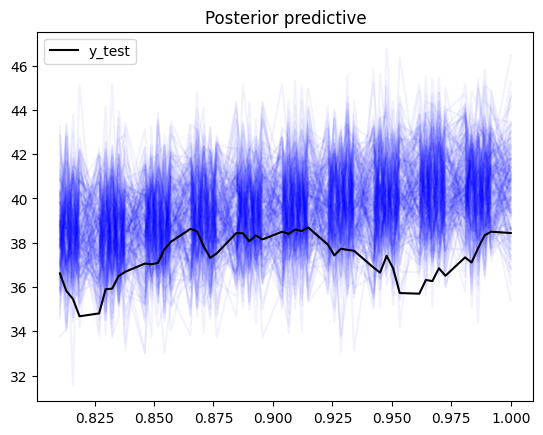

In [52]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(trace_post, group="posterior_predictive", num_samples=200)["likelihood"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [53]:
n_order = 3
def get_fourier(n_points,periods):

  x_f = np.linspace(0, periods, n_points)

  fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * x_f / periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
  )

  return fourier_features

In [54]:
coords = {"fourier_features": np.arange(2 * n_order)}
coords

{'fourier_features': array([0, 1, 2, 3, 4, 5])}

In [55]:
with pm.Model(coords=coords) as prophet_PETR4_p:
    X_ = pm.MutableData("X",x)
    y_ = pm.MutableData("y",y)
    n = X_.eval().shape[0]
    fs = get_fourier(n,7)
    fourier_f = pm.MutableData("f_f",fs.values)

    bp = pm.Normal('breakpoint', mu=0.4, sigma=0.1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope1 = pm.Normal('slope1', mu=1, sigma=1)
    slope2 = pm.Normal('slope2', mu=-1, sigma=1)

    β_fourier = pm.Normal("β_fourier", mu=0, sigma=1, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_f.T)
    )

    trend = tt.switch(X_ < bp,
              intercept + slope1 * X_,
              intercept + slope1 * bp + slope2 * (X_ - bp))

    trend = pm.Deterministic("trend", trend)

    μ = trend * (1 + seasonality)

    σ = pm.HalfNormal("σ", sigma=1)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y_)

In [56]:
with prophet_PETR4_p:
  p_prior_p = pm.sample_prior_predictive()

<ipython-input-57-b07d4e8675df>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior_predictive", num_samples=100)["likelihood"]
<ipython-input-57-b07d4e8675df>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior", num_samples=100)["trend"] * y_train.max(),
<ipython-input-57-b07d4e8675df>:21: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior", num_samples=100)["seasonality"]


Text(0.5, 1.0, 'Prior seasonality')

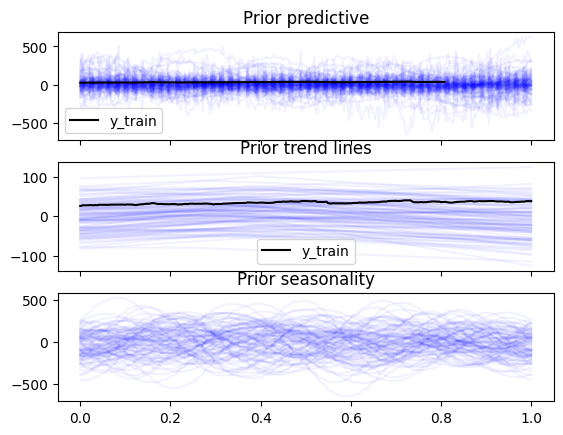

In [57]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
ax[0].plot(
    x,
    az.extract_dataset(p_prior_p, group="prior_predictive", num_samples=100)["likelihood"]
    * y.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x,
    az.extract_dataset(p_prior_p, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x.flatten(), y=y.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    x,
    az.extract_dataset(p_prior_p, group="prior", num_samples=100)["seasonality"]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")

In [58]:
with prophet_PETR4_p:
  trace_p_p = pm.sample()

In [59]:
with prophet_PETR4_p:
  trace_post_p = pm.sample_posterior_predictive(trace_p_p)

<ipython-input-60-056f1b266ff1>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],


Text(0.5, 1.0, 'Posterior predictive')

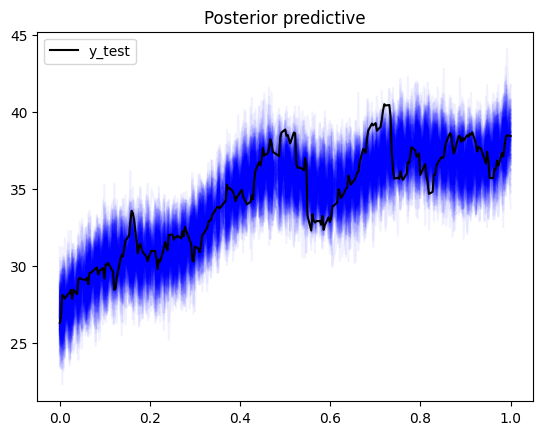

In [60]:
fig, ax = plt.subplots()
ax.plot(
    x,
    az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x.flatten(), y=y.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [61]:
y_pred = trace_post_p.posterior_predictive["likelihood"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y).sum()/len(y)}")

MAE: 1.0657579401504276


In [62]:
more_days = 2
new_points = np.arange(1,(more_days+max_day)/(max_day - min_day),1/(max_day-min_day))
new_points

array([1.        , 1.00274725])

In [63]:
vars = {}
vars["X"] = new_points
vars["y"] = np.zeros(len(new_points))
vars["f_f"] = get_fourier(len(new_points),7).values

In [64]:
with prophet_PETR4_p:
  pm.set_data(vars)
  trace_post_p_m = pm.sample_posterior_predictive(trace_p_p)

In [65]:
likelihood_values = trace_post_p_m.posterior_predictive["likelihood"].values
mean_likelihood = np.mean(likelihood_values, axis=(0, 1))
mean_likelihood

array([38.43010654, 38.43768827])

<ipython-input-66-f04311805441>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],
<ipython-input-66-f04311805441>:12: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p_m, group="posterior_predictive", num_samples=200)["likelihood"],


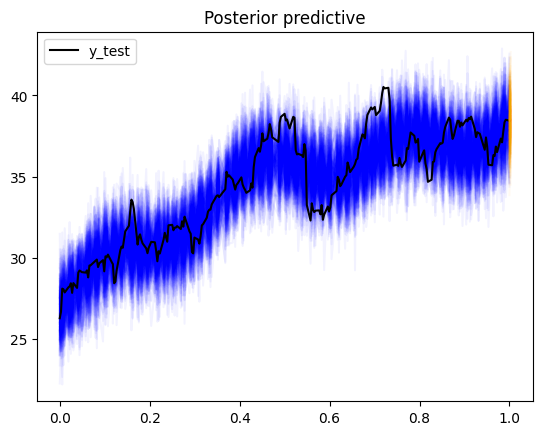

In [66]:
fig, ax = plt.subplots()
ax.plot(
    x,
    az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x.flatten(), y=y.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")
ax.plot(
    new_points,
    az.extract_dataset(trace_post_p_m, group="posterior_predictive", num_samples=200)["likelihood"],
    color="orange",
    alpha=0.05,
)

De acordo com o modelo, a predição para os próximos dois dias:

Dia 01 - $38.4301

Dia 02 - $38.4376

# 2. (5 pontos) Faça uma análise preditiva do dataset [Heart Disease ](https://archive.ics.uci.edu/dataset/45/heart+disease)

In [2]:
!pip install ucimlrepo

In [99]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)

# train, test = train_test_split(heart_disease, test_size=0.2, random_state=42, shuffle=True)
X_heart = heart_disease.data.features
y_heart = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

num ->  target

* age
* chol
* thalach
* trestbps


Próximas análises:
* sex - 0 (female) and 1 (male)
* oldpeak

In [71]:
X_heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


In [78]:
y_heart = y_heart.values.flatten()

In [104]:
n_train = round((303 * 80)/100)

In [113]:
x_heart_train = X_heart[:n_train]
y_heart_train = y_heart[:n_train].values.flatten()

x_heart_test = X_heart[n_train:]
y_heart_test = y_heart[n_train:].values.flatten()

In [114]:
x_heart_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
242,49,0,4,130,269,0,0,163,0,0.0,1,0.0,3.0
243,61,1,1,134,234,0,0,145,0,2.6,2,2.0,3.0
244,60,0,3,120,178,1,0,96,0,0.0,1,0.0,3.0
245,67,1,4,120,237,0,0,71,0,1.0,2,0.0,3.0
246,58,1,4,100,234,0,0,156,0,0.1,1,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


In [115]:
y_heart_train

array([0, 2, 1, 0, 0, 0, 3, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 3, 4, 0, 0, 0, 0, 3, 0, 2, 1, 0, 0, 0, 3, 1, 3, 0, 4, 0, 0, 0,
       1, 4, 0, 4, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2,
       1, 0, 2, 1, 0, 3, 1, 1, 1, 0, 1, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 3, 0, 2, 1, 2, 3,
       1, 1, 0, 2, 2, 0, 0, 0, 3, 2, 3, 4, 0, 3, 1, 0, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 3, 1, 0, 0, 1, 0, 1, 0, 1, 4, 0, 0, 0, 0, 0, 0, 4,
       3, 1, 1, 1, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 4, 1,
       0, 1, 0, 0, 3, 2, 0, 0, 1, 0, 0, 2, 1, 2, 0, 3, 1, 2, 0, 3, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 3, 3, 3, 0, 1, 0, 4, 0, 3, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 1, 0, 0, 0, 3, 2, 0, 2, 1, 0, 0, 3, 2, 1, 0, 0, 0, 0])

## Regressão Linear Múltipla

In [67]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [116]:
age = x_heart_train["age"].values
trestbps = x_heart_train["trestbps"].values
chol = x_heart_train["chol"].values
thalach = x_heart_train["thalach"].values

In [117]:
with pm.Model() as multi_linreg_heart:

    alpha = pm.Normal('alpha', 0, 100000)
    beta_trestbps = pm.Normal('beta_trestbps', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    epsilon = pm.HalfNormal('epsilon', 100)

    mu = alpha + beta_trestbps * trestbps + beta_age * age

    Y_obs = pm.Normal('Y_obs', mu, epsilon, observed=y_heart_train)

In [118]:
with multi_linreg_heart:
  prior_trace = pm.sample_prior_predictive()

In [119]:
prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<Axes: ylabel='Count'>

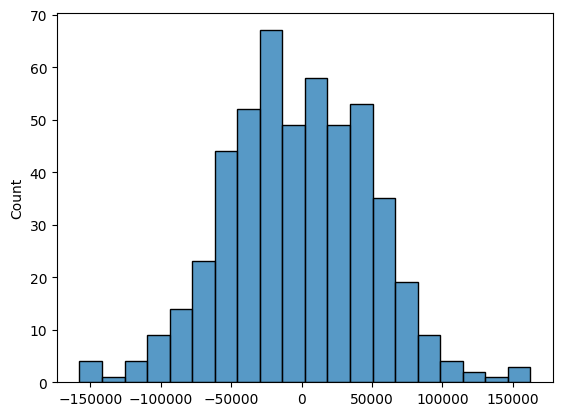

In [120]:
import seaborn as sns

sns.histplot(prior_trace.prior['beta_trestbps'].values.flatten(), bins=20)

<Axes: ylabel='Count'>

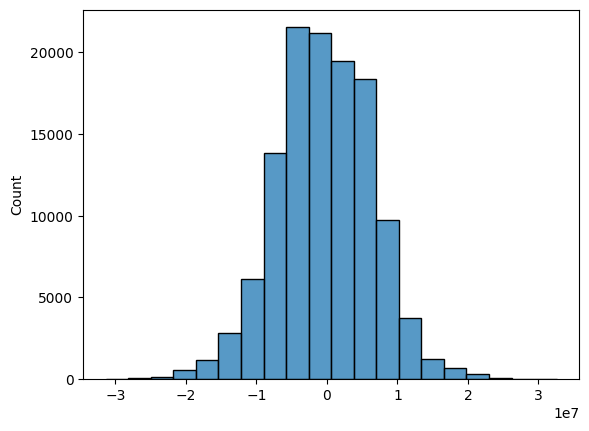

In [121]:
sns.histplot(prior_trace.prior_predictive['Y_obs'].values.flatten(), bins=20)

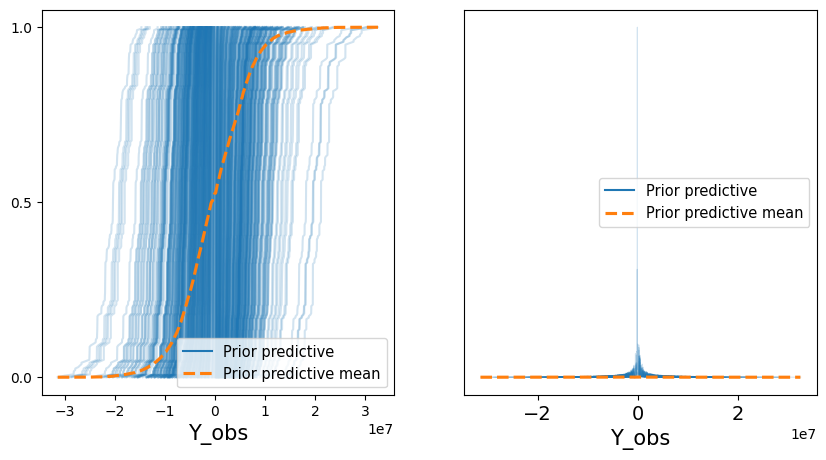

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(prior_trace, group='prior', kind='cumulative',ax=axes[0]);
az.plot_ppc(prior_trace, group='prior',ax=axes[1]);

In [123]:
with multi_linreg_heart:
  trace = pm.sample()

In [124]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.745,0.628,-2.948,-0.562,0.020,0.014,1019.0,1113.0,1.0
beta_age,0.030,0.009,0.013,0.046,0.000,0.000,1107.0,942.0,1.0
beta_trestbps,0.008,0.004,-0.000,0.016,0.000,0.000,1028.0,1151.0,1.0
epsilon,1.210,0.054,1.110,1.311,0.001,0.001,1574.0,1143.0,1.0


In [125]:
with multi_linreg_heart:
    trace_post = pm.sample_posterior_predictive(trace)

array([<Axes: xlabel='Y_obs'>], dtype=object)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


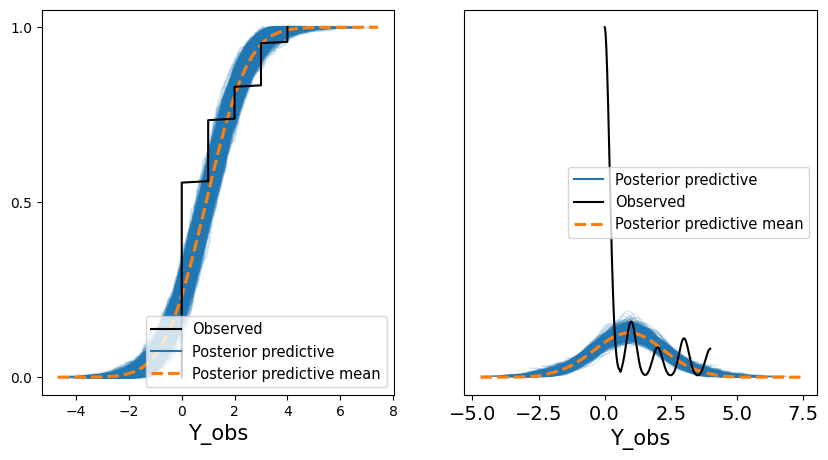

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_post, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(trace_post, group='posterior', ax=axes[1])

In [127]:
with pm.Model() as multi_linreg_heart_2:

    alpha = pm.Normal('alpha', 0, 100000)
    beta_trestbps = pm.Normal('beta_trestbps', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    beta_chol = pm.Normal('beta_chol', 0, 5)
    sigma = pm.HalfNormal('sigma', 1000)

    mu = alpha + beta_trestbps * trestbps + beta_age * age + beta_chol * chol

    Y_obs = pm.Normal('Y_obs', mu, sigma, observed=y_heart_train)

In [128]:
with multi_linreg_heart_2:
  trace_heart_2 = pm.sample()

In [129]:
pm.summary(trace_heart_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.734,0.703,-3.085,-0.475,0.022,0.016,1002.0,880.0,1.00
beta_age,0.029,0.010,0.010,0.046,0.000,0.000,1184.0,1183.0,1.01
beta_chol,0.000,0.002,-0.003,0.003,0.000,0.000,1363.0,1034.0,1.00
beta_trestbps,0.008,0.005,-0.002,0.017,0.000,0.000,1137.0,957.0,1.00
sigma,1.218,0.058,1.109,1.326,0.002,0.001,1401.0,1121.0,1.01


In [130]:
with multi_linreg_heart_2:
    trace_post_heart_2 = pm.sample_posterior_predictive(trace_heart_2)

array([<Axes: xlabel='Y_obs'>], dtype=object)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


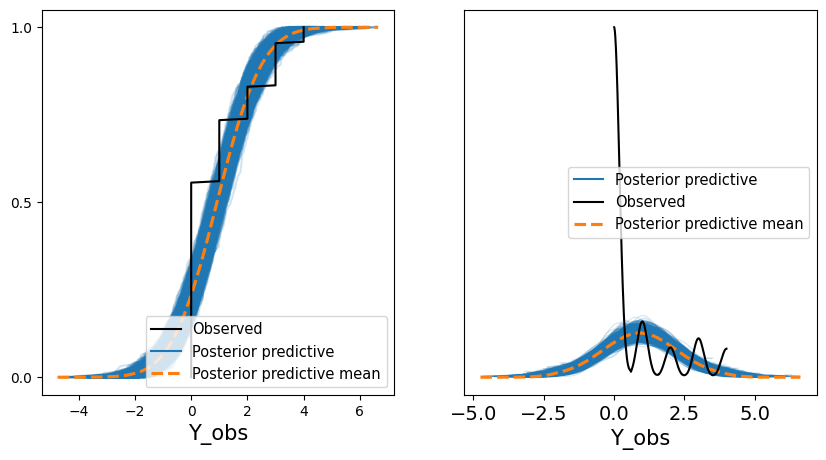

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_post_heart_2, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(trace_post_heart_2, group='posterior', ax=axes[1])

In [132]:
with pm.Model() as multi_linreg_heart_3:

    alpha = pm.Normal('alpha', 0, 100000)
    beta_trestbps = pm.Normal('beta_trestbps', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    beta_chol = pm.Normal('beta_chol', 0, 5)
    beta_thalach = pm.Normal('beta_thalach', 0, 5)
    sigma = pm.HalfNormal('sigma', 1000)

    mu = alpha + beta_trestbps * trestbps + beta_age * age + beta_chol * chol + beta_thalach * thalach

    Y_obs = pm.Normal('Y_obs', mu, sigma, observed=y_heart_train)

In [133]:
with multi_linreg_heart_3:
  trace_heart_3 = pm.sample()

In [134]:
pm.summary(trace_heart_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.712,0.931,0.995,4.393,0.031,0.022,929.0,1139.0,1.0
beta_age,0.006,0.009,-0.012,0.024,0.000,0.000,1298.0,1478.0,1.0
beta_chol,0.001,0.002,-0.002,0.004,0.000,0.000,1471.0,1096.0,1.0
beta_thalach,-0.023,0.004,-0.030,-0.017,0.000,0.000,1167.0,1282.0,1.0
beta_trestbps,0.009,0.004,0.002,0.018,0.000,0.000,1589.0,1336.0,1.0
sigma,1.119,0.052,1.020,1.213,0.001,0.001,1757.0,1408.0,1.0


In [135]:
with multi_linreg_heart_3:
    trace_post_heart_3 = pm.sample_posterior_predictive(trace_heart_3)

array([<Axes: xlabel='Y_obs'>], dtype=object)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


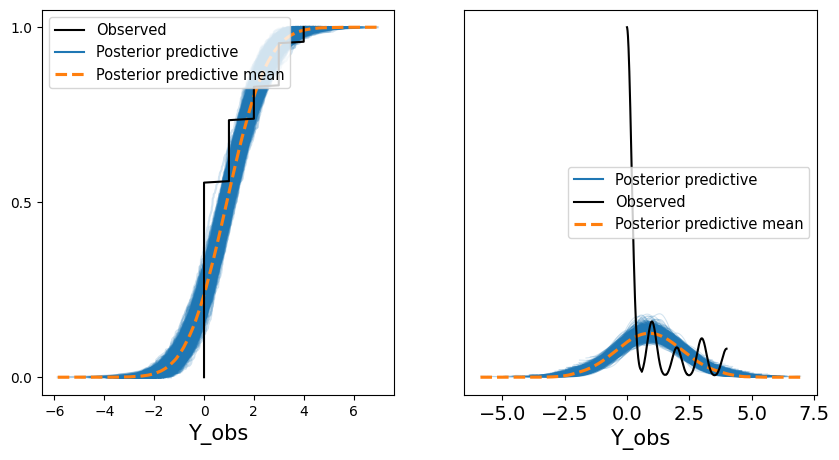

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_post_heart_3, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(trace_post_heart_3, group='posterior', ax=axes[1])

In [137]:
with pm.Model() as multi_linreg_heart3_t:

    alpha = pm.Normal('alpha', 0, 100000)
    beta_trestbps = pm.Normal('beta_trestbps', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    beta_chol = pm.Normal('beta_chol', 0, 5)
    beta_thalach = pm.Normal('beta_thalach', 0, 5)
    sigma = pm.HalfNormal('sigma', 10000)

    mu = alpha + beta_trestbps * trestbps + beta_age * age + beta_chol * chol + beta_thalach * thalach
    df = pm.Exponential("df",1)
    Y_obs = pm.StudentT('Y_obs', nu=df, mu=mu, sigma=sigma, observed=y_heart_train)

In [138]:
with multi_linreg_heart3_t:
  trace_p = pm.sample()

In [139]:
pm.summary(trace_p)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.091,0.921,1.434,4.862,0.030,0.021,945.0,1036.0,1.0
beta_age,-0.002,0.009,-0.020,0.015,0.000,0.000,1280.0,1250.0,1.0
beta_chol,0.001,0.001,-0.002,0.003,0.000,0.000,1332.0,1021.0,1.0
beta_thalach,-0.024,0.003,-0.031,-0.018,0.000,0.000,1069.0,1218.0,1.0
beta_trestbps,0.009,0.004,0.002,0.016,0.000,0.000,1118.0,1372.0,1.0
df,3.629,1.101,1.751,5.597,0.034,0.024,997.0,831.0,1.0
sigma,0.817,0.084,0.661,0.983,0.003,0.002,982.0,806.0,1.0


In [140]:
with multi_linreg_heart3_t:
    trace_post_t = pm.sample_posterior_predictive(trace_p)

array([<Axes: xlabel='Y_obs'>], dtype=object)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


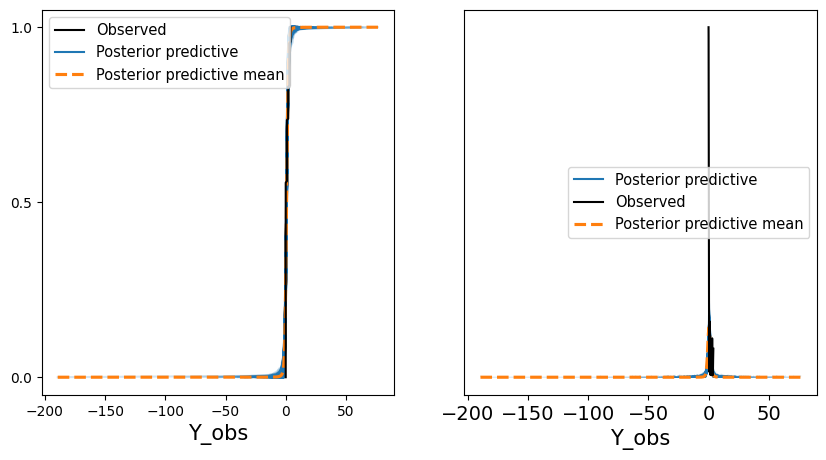

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_post_t, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(trace_post_t, group='posterior', ax=axes[1])

## Compare

In [142]:
with multi_linreg_heart:
    pm.compute_log_likelihood(trace)

with multi_linreg_heart_2:
    pm.compute_log_likelihood(trace_heart_2)

with multi_linreg_heart_3:
    pm.compute_log_likelihood(trace_heart_3)

with multi_linreg_heart3_t:
    pm.compute_log_likelihood(trace_p)

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

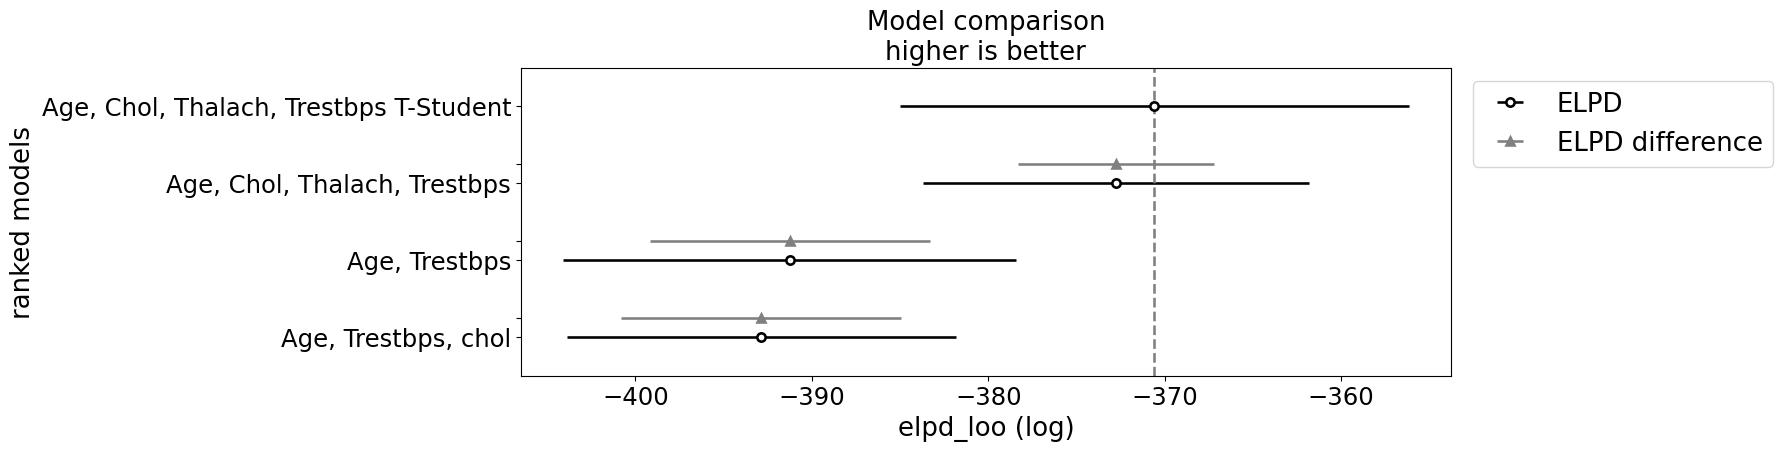

In [143]:
model_compare = az.compare(
    {
        "Age, Chol, Thalach, Trestbps T-Student": trace_p,
        "Age, Trestbps": trace,
        "Age, Trestbps, chol": trace_heart_2,
        "Age, Chol, Thalach, Trestbps": trace_heart_3
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

In [144]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
"Age, Chol, Thalach, Trestbps T-Student",0,-370.603107,9.252330,0.000000,0.630680,14.420761,0.000000,False,log
"Age, Chol, Thalach, Trestbps",1,-372.770719,6.782595,2.167611,0.367701,10.932465,5.555992,False,log
"Age, Trestbps",2,-391.253480,3.869599,20.650373,0.001318,12.836273,7.938400,False,log
"Age, Trestbps, chol",3,-392.855733,5.468753,22.252625,0.000301,11.019169,7.931665,False,log


O modelo escolhido será com as colunas Age, Chol, Thalach e Trestbps. Agora será realizado a parte de gerar dados preditivos a partir do modelo vencedor de acordo com o crtério ELPD LOO.


In [145]:
x_heart_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
242,49,0,4,130,269,0,0,163,0,0.0,1,0.0,3.0
243,61,1,1,134,234,0,0,145,0,2.6,2,2.0,3.0
244,60,0,3,120,178,1,0,96,0,0.0,1,0.0,3.0
245,67,1,4,120,237,0,0,71,0,1.0,2,0.0,3.0
246,58,1,4,100,234,0,0,156,0,0.1,1,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


In [146]:
y_heart_test

array([0, 2, 0, 2, 2, 1, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0,
       4, 2, 2, 2, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 3, 0, 2, 4,
       2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 3, 1, 1, 2, 3, 1, 0])

In [147]:
age_test = x_heart_test['age'].values
chol_test = x_heart_test['chol'].values
thalach_test = x_heart_test['thalach'].values
trestbps_test = x_heart_test['trestbps'].values

In [148]:
with pm.Model() as multi_linreg_heart_mutable:
    a_m = pm.MutableData('a_m', age)
    c_m = pm.MutableData('c_m', chol)
    tha_m = pm.MutableData('tha_m', thalach)
    tre_m = pm.MutableData('tre_m', trestbps)
    y = pm.MutableData('y_m', y_heart_train)
    alpha = pm.Normal('alpha', 0, 100000)
    beta_trestbps = pm.Normal('beta_trestbps', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    beta_chol = pm.Normal('beta_chol', 0, 5)
    beta_thalach = pm.Normal('beta_thalach', 0, 5)
    sigma = pm.HalfNormal('sigma', 10000)

    mu = alpha + beta_trestbps * tre_m + beta_age * a_m + beta_chol * c_m + beta_thalach * tha_m
    df = pm.Exponential("df",1)
    Y_obs = pm.StudentT('Y_obs', nu=df, mu=mu, sigma=sigma, observed=y)

In [149]:
with multi_linreg_heart_mutable:
  trace_p_mutable = pm.sample()

In [150]:
with multi_linreg_heart_mutable:

    pm.set_data({
        "a_m": age_test,
        "c_m": chol_test,
        "tha_m": thalach_test,
        "tre_m": trestbps_test,
        "y_m":y_heart_test})

In [151]:
with multi_linreg_heart_mutable:
    ppc = pm.sample_posterior_predictive(trace_p_mutable)

In [152]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [155]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_heart_values_test = y_heart_test

y_heart_predictive = ppc.posterior_predictive["Y_obs"].mean(["chain","draw"]).to_numpy()

mae = mean_absolute_error(y_heart_values_test, y_heart_predictive)
rmse = mean_squared_error(y_heart_values_test, y_heart_predictive, squared=False)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.8746777673462804
RMSE: 1.121838840235096
